In [1]:
import sys
sys.path.insert(0, '../..')

import graph_class as g
import itertools
import numpy as np
import time
import random as rd
from matplotlib import pyplot as plt
import os
import pandas as pd


# Importing 3 graphs from TSPLIB

In [2]:
berlin52 = g.heidelberg_2D(filename="../../data/berlin52.tsp")
a280 = g.heidelberg_2D(filename="../../data/a280.tsp")
pcb442 = g.heidelberg_2D(filename="../../data/pcb442.tsp")

# Plotting optimal tours as given in TSPLIB

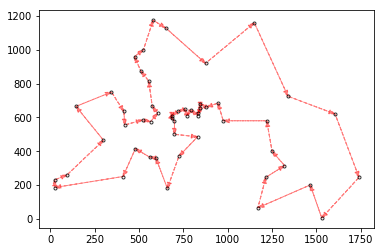

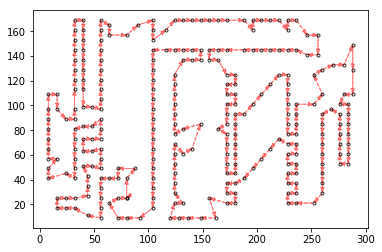

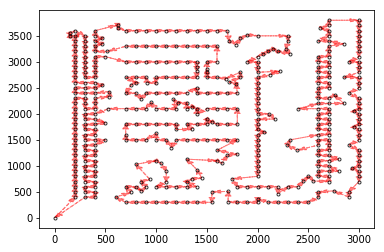

In [30]:
# we fetch and plot the optimal tours for 3 graphs ("small", "medium", "big")
berlin52_opt_nodes = g.heidelberg_optimal_tour(filename=cwd+"../../data/berlin52.opt.tour")
berlin52_optimal_tour = [berlin52.vertices[index] for index in berlin52_opt_nodes]
g.plotTSP_2D(berlin52_optimal_tour)

a280_opt_nodes = g.heidelberg_optimal_tour(filename=cwd+"../../data/a280.opt.tour")
a280_optimal_tour = [a280.vertices[index] for index in a280_opt_nodes]
g.plotTSP_2D(a280_optimal_tour)

pcb442_opt_nodes = g.heidelberg_optimal_tour(cwd+"../../data/pcb442.opt.tour")
pcb442_optimal_tour = [pcb442.vertices[index] for index in pcb442_opt_nodes]
g.plotTSP_2D(pcb442_optimal_tour)

# Implemeting Simulated Annealing

In [5]:
def greedy_just_for_sa(graph):
    #For the sake of completeness, we show the greedy algorithm implemented elsewhere, which is use in the
    #initialization of the simulated annealing algorithm
    adj_mat = graph.weighted_adjacency_matrix
    nNodes = len(adj_mat)
    firstMove = np.unravel_index(np.argmin(adj_mat),adj_mat.shape)
    listOfTraversedNodes = [firstMove[0],firstMove[1]]
    cost = adj_mat[firstMove[0],firstMove[1]]
    while len(listOfTraversedNodes) < len(adj_mat):
        currentCosts = list(adj_mat[listOfTraversedNodes[-1],:])
        for idx2 in listOfTraversedNodes:
            currentCosts[idx2] = np.inf
        listOfTraversedNodes.append(np.argmin(currentCosts))
        cost += adj_mat[listOfTraversedNodes[-2],listOfTraversedNodes[-1]]
    cost += adj_mat[listOfTraversedNodes[-1],listOfTraversedNodes[0]]
    return listOfTraversedNodes

In [6]:
def simulated_annealing(graph, iterations=0, greedy_start = True, temperature=10,
           cooling_factor = 0.99999, return_graph = False, method = "2-OPT", break_time = 600):
    
    start = time.time()
    
    if greedy_start:
        nodes = [graph.vertices[index] for index in greedy_just_for_sa(graph)]
    else:
        nodes = np.random.permutation(graph.vertices)
    
    
    current_min = graph.get_cycle_weight(nodes)
    
    while temperature>1:
        #difference in paths can't be greater than one
        #for very small T, e^{-\DeltaE/T} is going accept small \Delta E with great likelihood

            #generate random nodes 
            k = np.random.randint(0,len(nodes))
            p = np.random.randint(k,len(nodes))

            test_nodes = nodes.copy()
            
            # method 2-OPT inverts all vertices between k and p
            # method SHUFFLE permutes them randomly
            # As discussed in the report, there are many other possible ways to search the
            # neigbourhood of the current cycle
            # A reasonable modification would be to make the generation of k and p above
            # temperature-dependent (smaller distance for lower temperatures)
            if method == "SHUFFLE":
                np.random.shuffle(test_nodes[k:p])
            elif method == "2-OPT":
                test_nodes[k:p] = np.flip(test_nodes[k:p], axis=0)

            current_path_length = graph.get_cycle_weight(nodes)
            test_path_length = graph.get_cycle_weight(test_nodes)

            # Boltzmann distribution
            Delta_Length = test_path_length - current_path_length
            p = min(np.exp(-(Delta_Length)/(temperature)),1)
            
            # testing a few hundred runs shows that <= is marginally better on average,
            # but better at finding minima, since variance tends to be greater
            # I believe this happens because always accepting same-length configurations
            # allows it to explore the solution space better
            if Delta_Length <= 0:
                nodes = test_nodes.copy()

            elif p > np.random.rand():
                    nodes = test_nodes.copy()
            #kirpatrick cooling(http://citeseer.ist.psu.edu/kirkpatrick83optimization.html)
            temperature = temperature*cooling_factor
            if iterations>0:
                if temperature <1:
                    temperature = 100
                    iterations-=1
            
            if time.time()-start > break_time:
                break
    end = time.time()
    if return_graph:
        node_output = g.plotTSP_2D(nodes)
    else:
        node_output = nodes
    return end-start, graph.get_cycle_weight(nodes), node_output

In [11]:
results = []

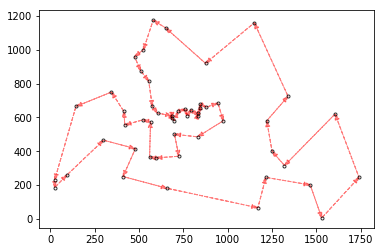

In [10]:
t,w,n = simulated_annealing(berlin52, iterations=0, temperature=10, greedy_start=True, method='2-OPT', return_graph=True)
results.append([t,w])

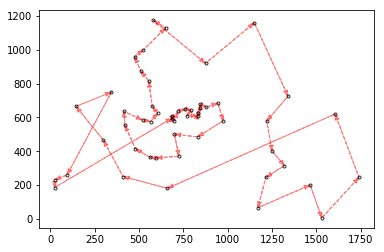

In [13]:
t,w,n = simulated_annealing(berlin52, iterations=0, temperature=0, greedy_start=True, method='2-OPT', return_graph=True)
results.append([t,w])

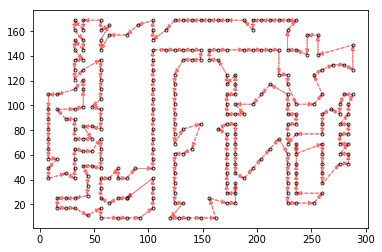

In [15]:
t,w,n = simulated_annealing(a280, iterations=0, temperature=10, greedy_start=True, method='2-OPT', return_graph=True)
results.append([t,w])

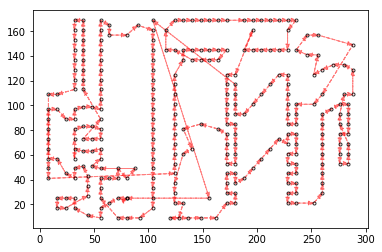

In [17]:
t,w,n = simulated_annealing(a280, iterations=0, temperature=0, greedy_start=True, method='2-OPT', return_graph=True)
results.append([t,w])

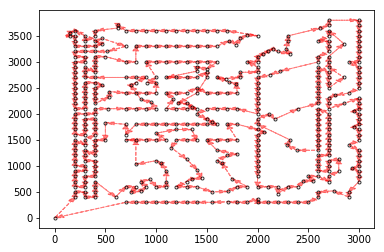

In [19]:
t,w,n = simulated_annealing(pcb442, iterations=0, temperature=10, greedy_start=True, method='2-OPT', return_graph=True)
results.append([t,w])

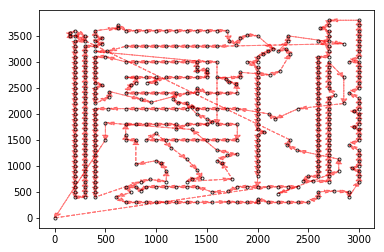

In [21]:
t,w,n = simulated_annealing(pcb442, iterations=0, temperature=0, greedy_start=True, method='2-OPT', return_graph=True)
results.append([t,w])

# Putting results in a dataframe for visualization

In [80]:
b = berlin52.get_cycle_weight(berlin52_optimal_tour)
a = a280.get_cycle_weight(a280_optimal_tour)
p = pcb442.get_cycle_weight(pcb442_optimal_tour)
optimals = pd.DataFrame([b,b,a,a,p,p])

results_df = pd.DataFrame(results, columns= ["runtime", "path length"])
results_df["method"] = ["SA", "Greedy", "SA", "Greedy", "SA", "Greedy"]
results_df["optimals"] = [b,b,a,a,p,p]
results_df["size"] = [52, 52, 280, 280, 442, 442]
results_df["% above optimal path length"] = results_df["path length"]/results_df["optimals"]-1

results_df = results_df.set_index(['method', 'size'])

## Table

In [85]:
results_df

,,runtime,path length,optimals,% above optimal path length
method,size,,,,
SA,52,28.703752,8182,7542,0.084858
Greedy,52,0.002022,9161,7542,0.214665
SA,280,136.039083,2807,2579,0.088406
Greedy,280,0.021960,3197,2579,0.239628
SA,442,216.557764,55701,50778,0.096951
Greedy,442,0.037792,64566,50778,0.271535


## SA, Greedy, Optimal pathlenghts bargraph

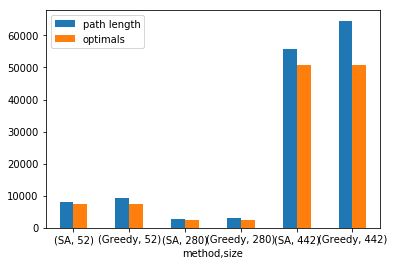

In [81]:
results_df[["path length", "optimals"]].plot.bar(rot=0)

## Runtime bargraph
Note the log scale, since runtimes are 4 orders of magnitude apart

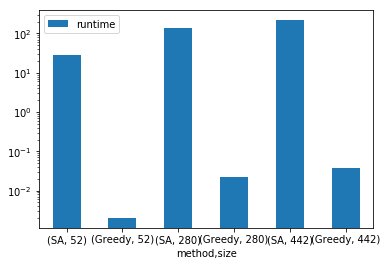

In [82]:
results_df[["runtime"]].plot.bar(rot=0, logy = True)

## Percent over optimal path length bargraph
Note that Greedy percentage over path length seems to be increasing with graph size much faster than SA's!

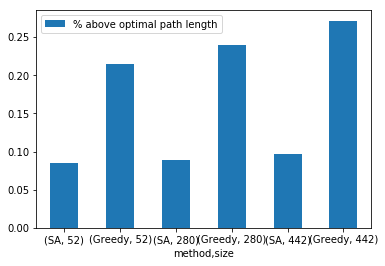

In [84]:
results_df[["% above optimal path length"]].plot.bar(rot=0)